Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

In [18]:
!pip install -q numpy pandas matplotlib seaborn 
!pip install -q torchvision torchinfo


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import copy
import time
import os
import pickle


### Helper Functions - Save and Load Models

In [52]:
# Utility functions for saving and loading models
# will use to cache experiments to avoid retraining models and to allow reproducible results
def save_model(model, filename, directory='saved_models'):
    """Save a model to disk
    Args:
        model: The model to save
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to save in (will be created if it doesn't exist)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filepath = os.path.join(directory, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
def load_model(filename, directory='saved_models'):
    """Load a model from disk
    Args:
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to load from
    Returns:
        The loaded model
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
        
    filepath = os.path.join(directory, filename)
    if not os.path.exists(filepath):
        print(f"No saved model found at {filepath}")
        return None
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

# Task 1: Acquire the data

In [5]:
# find mean & std for train_dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
loader_iter = iter(loader)
images, _ = next(loader_iter)
mean_train = images.mean().item()
std_train = images.std().item()
print((mean_train, std_train))

# normalize train_dataset & test_dataset
mlp_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
    transforms.Lambda(lambda x:x.view(-1))
])

full_train_dataset_normalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform)
test_dataset_normalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_normalized))
val_size = len(full_train_dataset_normalized) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_normalized, val_dataset_normalized = random_split(full_train_dataset_normalized, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False, generator=generator)

# sanity check
x, y = next(iter(train_loader))
print((x.shape, y.shape)) # expect [64, 784] and [64]
input_size = x.shape[1]
output_size = len(set(full_train_dataset_normalized.targets.numpy()))
print(input_size, output_size)

(0.28604060411453247, 0.3530242443084717)
(torch.Size([64, 784]), torch.Size([64]))
784 10


# Task 2: Implement a Multilayer Perceptron

In [69]:
import importlib
import mlp                # only required if not already imported
importlib.reload(mlp)     # reloads the module from disk
from mlp import MLP, softmax, evaluate_acc  # rebinds names in notebook namespace

import activation_functions
importlib.reload(activation_functions)  # reloads the module from disk
from activation_functions import relu, leakyRelu, sigmoid, tanh  # rebinds names in notebook namespace

# Task 3: Run the experiments and report

## 3.1: MLPs with Different Depths

### No Hidden Layers

Model loaded from saved_models/model1.1.pkl


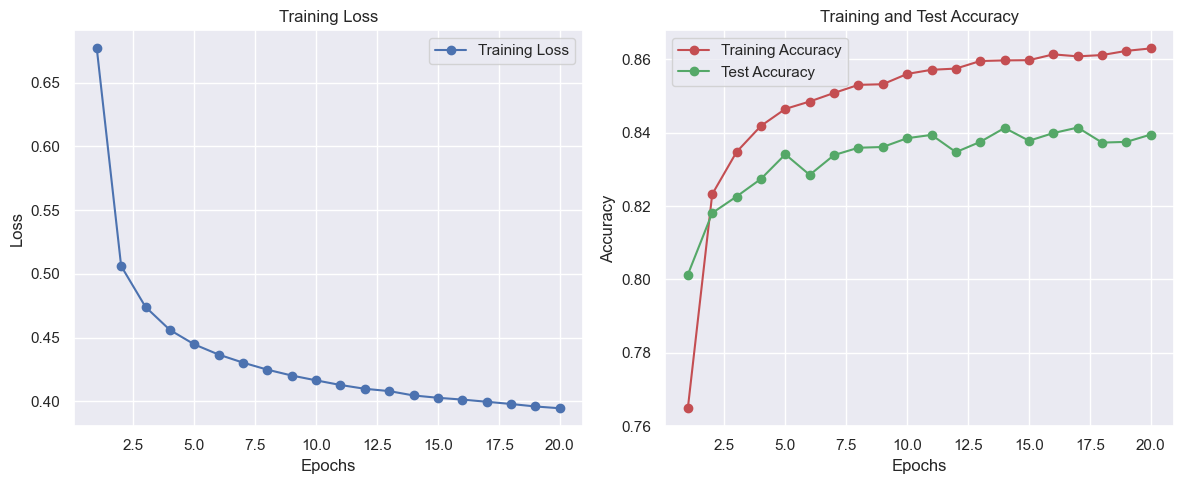

In [41]:
# Model 1 - No hidden layers, ReLU activation
model1 = load_model('model1.1')
if model1 is None: 
    model1 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=0, units=[])
    model1.fit(train_loader, test_loader, 0.01, 20) 
    model1.plot_history()
    save_model(model1, 'model1.1')
else: 
    model1.plot_history()

### One Hidden Layer

Model loaded from saved_models/model1.2.pkl


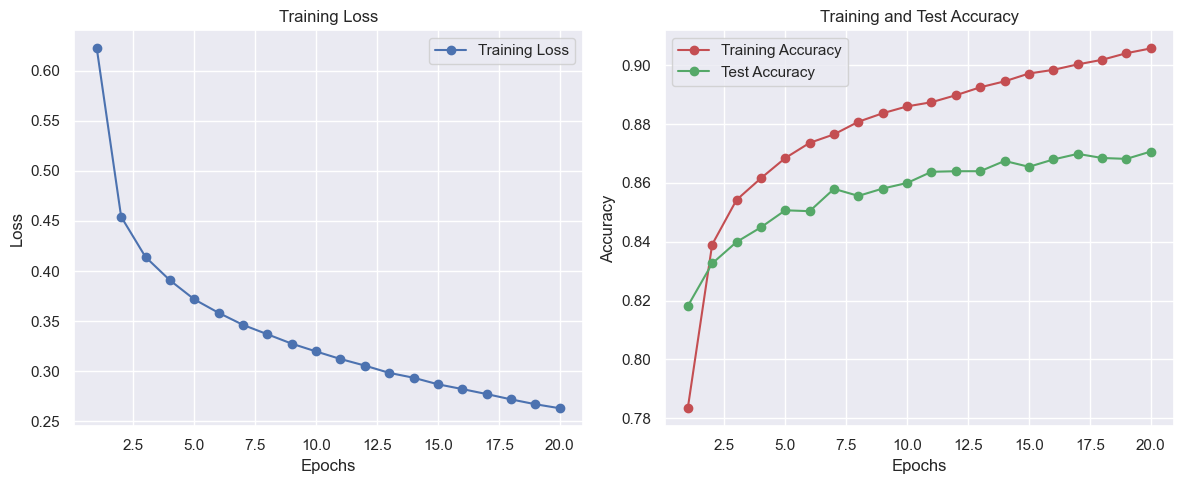

In [42]:
# Model 2 - One hidden layer with 256 units, ReLU activation
model2 = load_model('model1.2')
if model2 is None: 
    model2 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=1, units=[256])
    model2.fit(train_loader, test_loader, 0.01, 20) 
    model2.plot_history()
    save_model(model2, 'model1.2')
else: 
    model2.plot_history()

### Two Hidden Layers

Model loaded from saved_models/model1.3.pkl


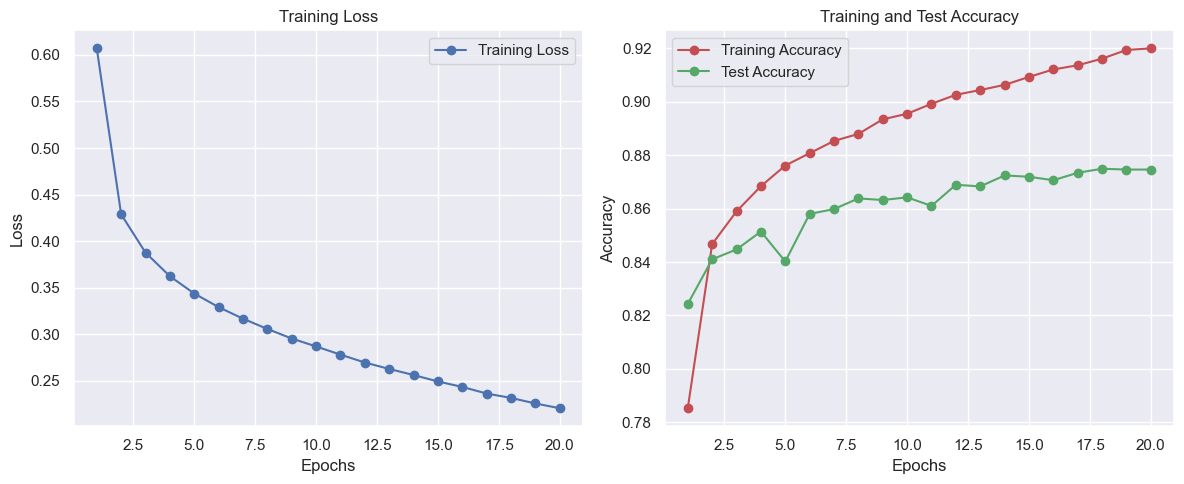

In [45]:
# Model 3 - Two hidden layers with 256 units each, ReLU activation
model3 = load_model('model1.3')
if model3 is None: 
    model3 = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model3.fit(train_loader, test_loader, 0.01, 20) 
    model3.plot_history()
    save_model(model3, 'model1.3')
else: 
    model3.plot_history()

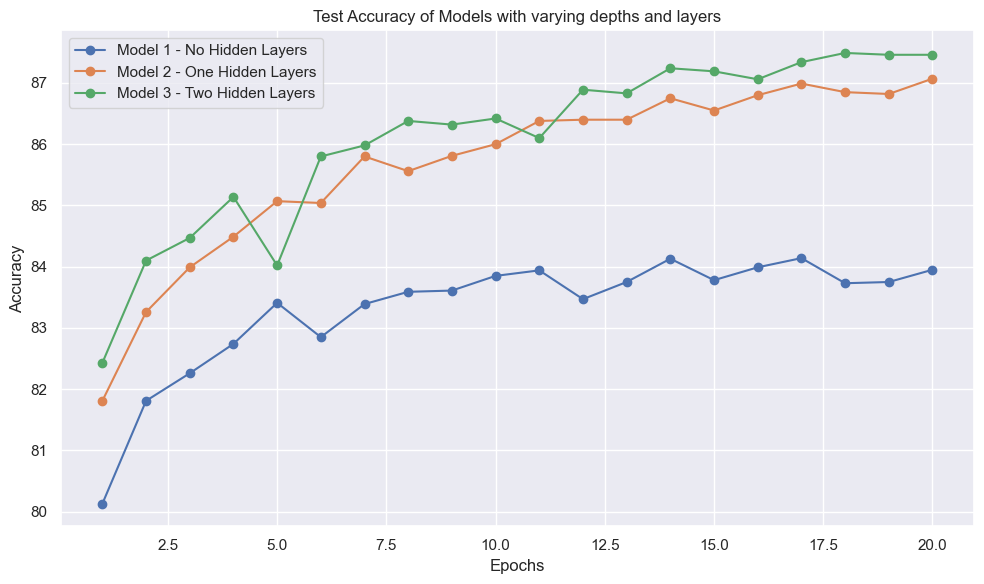

In [46]:
# Comparison of models test accuracy
models = [('Model 1 - No Hidden Layers', model1), ('Model 2 - One Hidden Layers', model2), ('Model 3 - Two Hidden Layers', model3)]
plt.figure(figsize=(10, 6))
for model_name, model in models:
    if model is None: 
        continue
    epochs = range(1, len(model.loss_history) + 1)
    plt.plot(epochs, [a*100 for a in model.test_accuracy_history], marker='o', label=model_name)
plt.title('Test Accuracy of Models with varying depths and layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2: Activation Function Comparison

### Two Hidden Layers - Tanh Activation

Model loaded from saved_models/model2.1.pkl


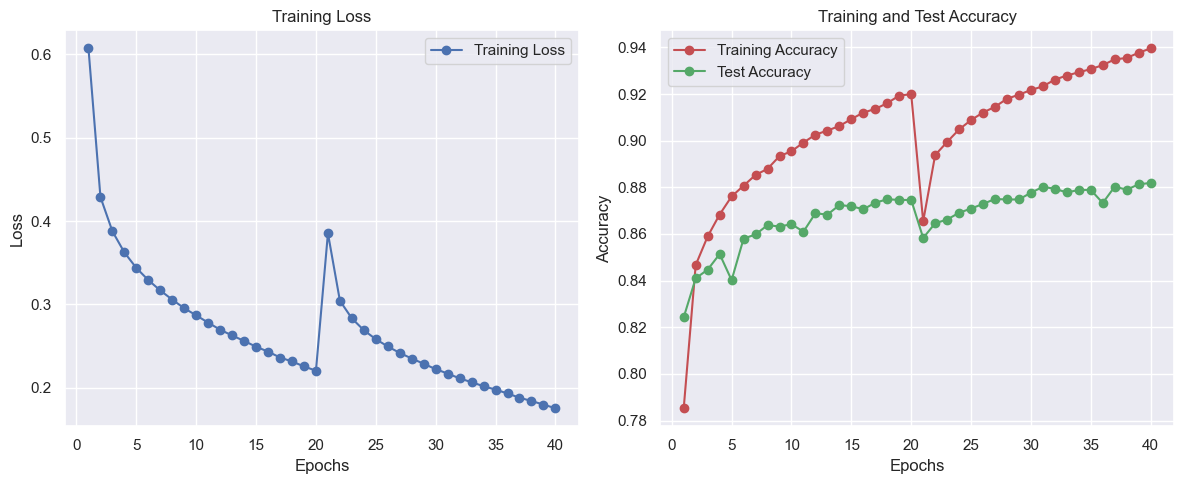

In [71]:
# Copy of model with 2 hidden layers with tanh activation function
model3_tanh = load_model('model2.1')
if model3_tanh is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_tanh = copy.deepcopy(model3_ReLU)
        model3_tanh.activation_function = tanh()
        model3_tanh.fit(train_loader, test_loader, 0.01, 20)
        model3_tanh.plot_history()
        save_model(model3_tanh, 'model2.1')
else: 
    model3_tanh.plot_history()

### Two Hidden Layers - Leaky ReLU Activation

Model loaded from saved_models/model2.2.pkl


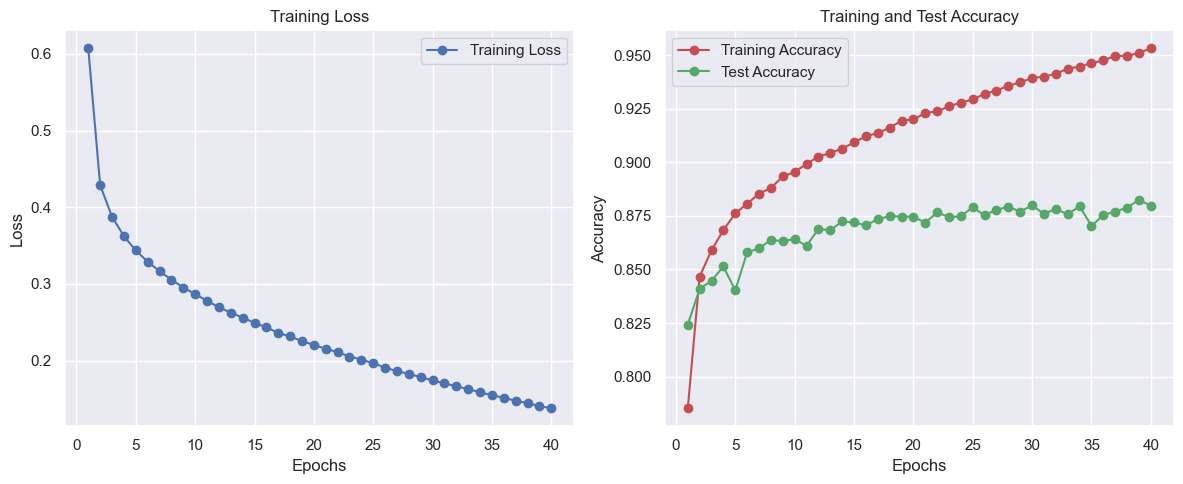

In [73]:
# Copy of model with 2 hidden layers with leaky ReLU activation function
model3_leakyReLU = load_model('model2.2')
if model3_leakyReLU is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_leakyReLU = copy.deepcopy(model3_ReLU)
        model3_leakyReLU.activation_function = leakyRelu()
        model3_leakyReLU.fit(train_loader, test_loader, 0.01, 20)
        model3_leakyReLU.plot_history()
        save_model(model3_leakyReLU, 'model2.2')
else: 
    model3_leakyReLU.plot_history()

### Two Hidden Layers - Sigmoid

Model loaded from saved_models/model2.3.pkl


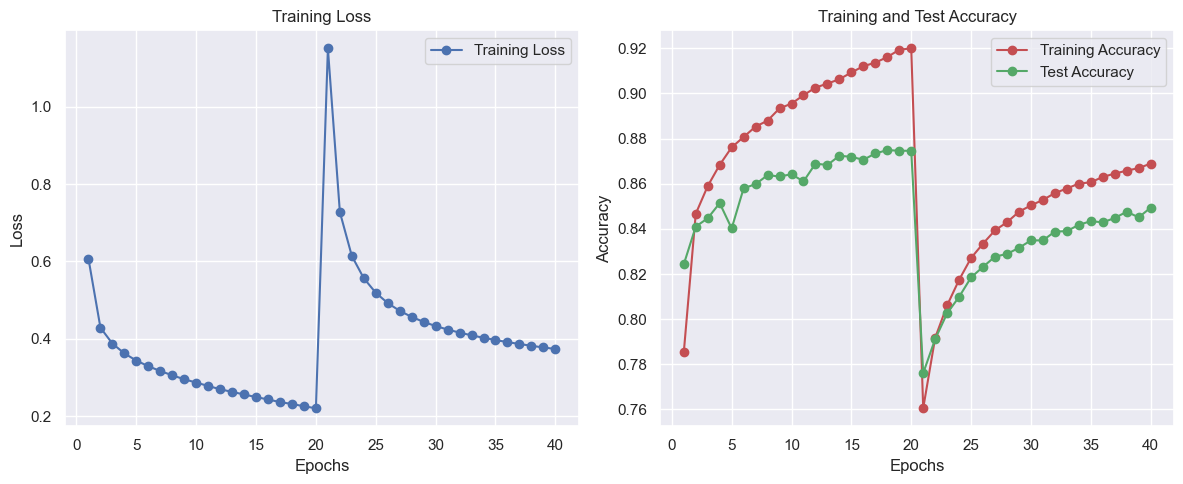

In [76]:
# Copy of model with 2 hidden layers with leaky ReLU activation function
model3_sigmoid = load_model('model2.3')
if model3_sigmoid is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_sigmoid = copy.deepcopy(model3_ReLU)
        model3_sigmoid.activation_function = sigmoid()
        model3_sigmoid.fit(train_loader, test_loader, 0.01, 20)
        model3_sigmoid.plot_history()
        save_model(model3_sigmoid, 'model2.3')
else: 
    model3_sigmoid.plot_history()

### Two Hidden Layers - ReLU

Model loaded from saved_models/model2.4.pkl


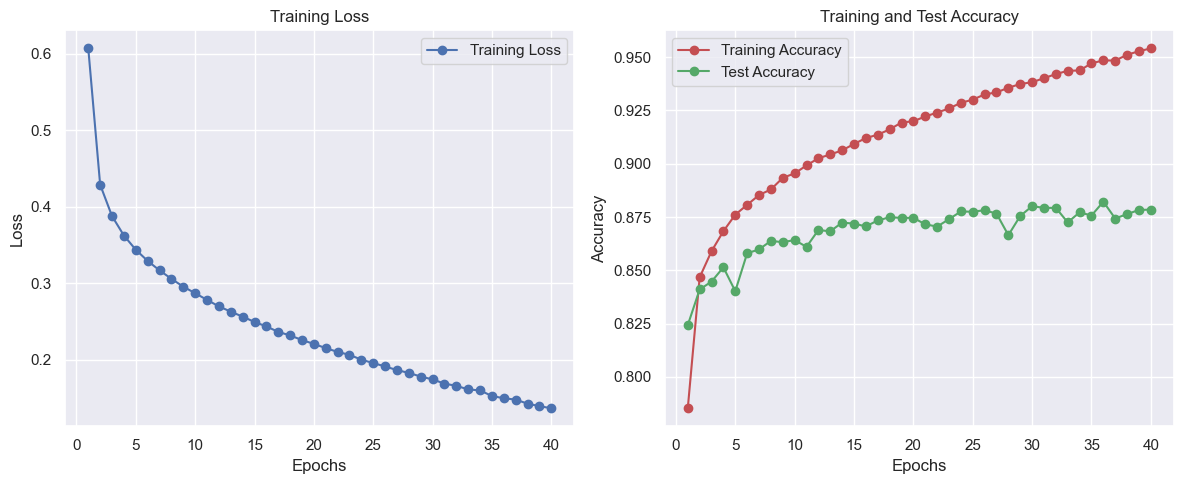

In [79]:
# Retrain model with 2 hidden layers 20 more times
model3_ReLU_Extra = load_model('model2.4')
if model3_ReLU_Extra is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_ReLU_Extra = copy.deepcopy(model3_ReLU)
        model3_ReLU_Extra.fit(train_loader, test_loader, 0.01, 20)
        model3_ReLU_Extra.plot_history()
        save_model(model3_ReLU_Extra, 'model2.4')
else: 
    model3_ReLU_Extra.plot_history()

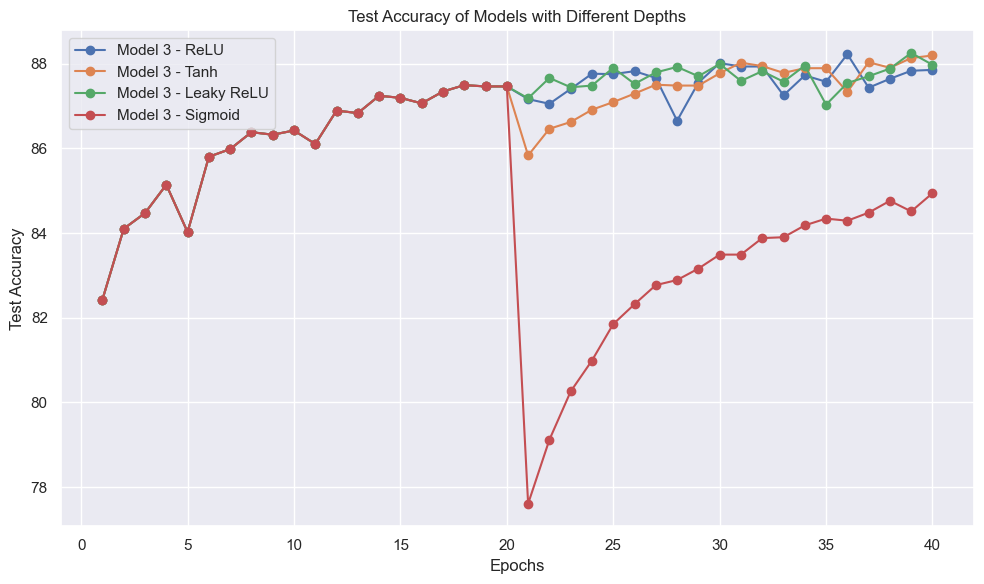

In [80]:
# Comparison of models test accuracy
models = [('Model 3 - ReLU', model3_ReLU_Extra), ('Model 3 - Tanh', model3_tanh), ('Model 3 - Leaky ReLU', model3_leakyReLU), ('Model 3 - Sigmoid', model3_sigmoid)]
plt.figure(figsize=(10, 6))
for model_name, model in models:
    epochs = range(1, len(model.loss_history) + 1)
    plt.plot(epochs, [a*100 for a in model.test_accuracy_history], marker='o', label=model_name)
plt.title('Test Accuracy of Models with Different Depths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.3: L1 and L2 Regularization

### L1 Regularization

Model loaded from saved_models\model3_lambda1_0.0.pkl
Model loaded from saved_models\model3_lambda1_0.0001.pkl
Model loaded from saved_models\model3_lambda1_0.001.pkl
Model loaded from saved_models\model3_lambda1_0.01.pkl
Model loaded from saved_models\model3_lambda1_0.1.pkl
Model loaded from saved_models\model3_lambda1_1.0.pkl


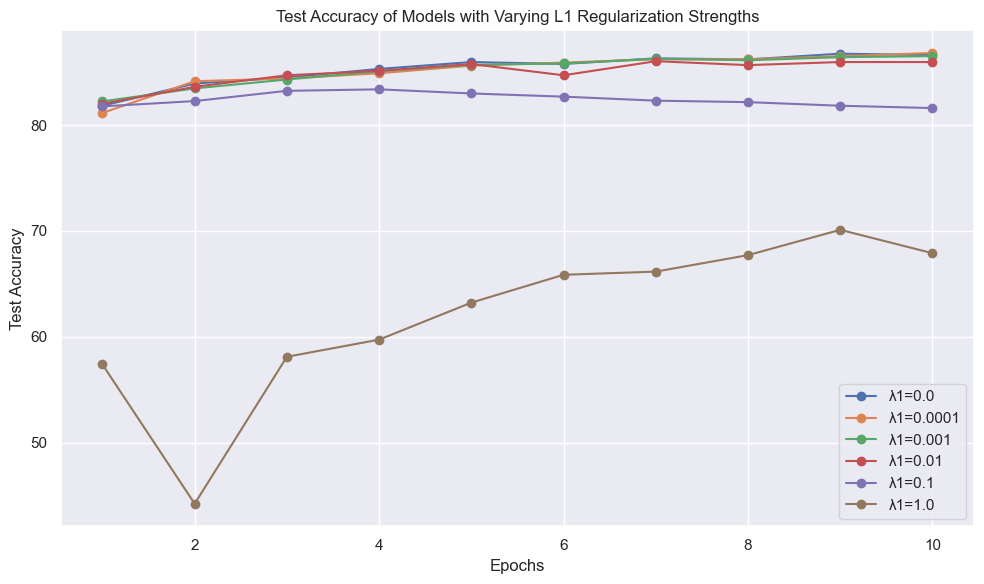

In [ ]:
# Experimenting with L1 regularization strengths
lambda_ranges = np.concatenate((np.array([0]), np.logspace(-4, 0, 5)))
plt.figure(figsize=(10, 6))
for i, l in enumerate(lambda_ranges):
    model = load_model(f'model3_lambda1_{l}')
    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit(train_loader, test_loader, 0.01, 10, lambda_l1=l)
        save_model(model, f'model3_lambda1_{l}')
    plt.plot(range(1, len(model.test_accuracy_history) + 1), [a*100 for a in model.test_accuracy_history], marker='o', label=f'λ1={l}')

plt.title('Test Accuracy of Models with Varying L1 Regularization Strengths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### L2 Regularization

Model loaded from saved_models\model3_lambda2_0.0.pkl
Model loaded from saved_models\model3_lambda2_0.0001.pkl
Model loaded from saved_models\model3_lambda2_0.001.pkl
Model loaded from saved_models\model3_lambda2_0.01.pkl
Model loaded from saved_models\model3_lambda2_0.1.pkl
Model loaded from saved_models\model3_lambda2_1.0.pkl


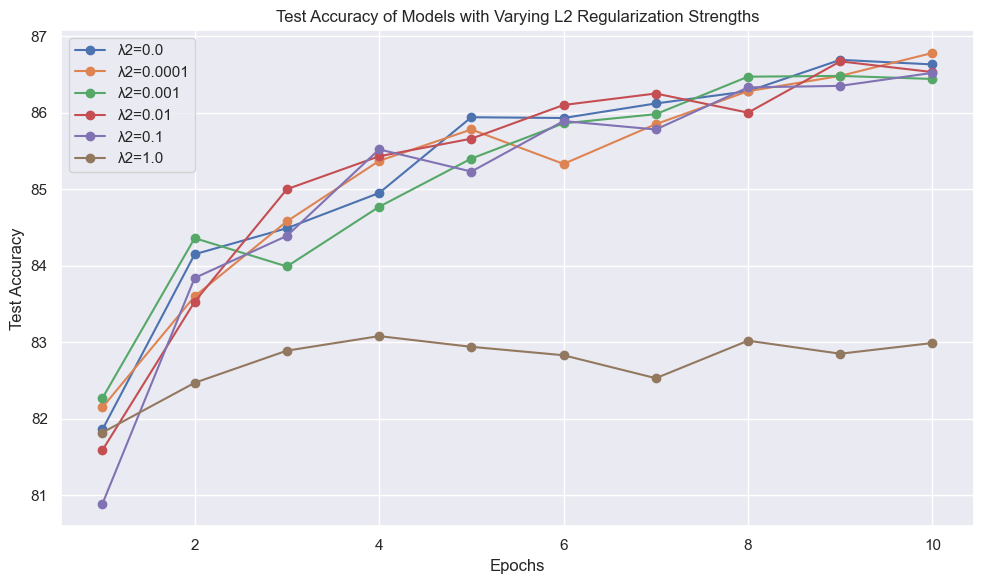

In [ ]:
# Experimenting with L2 regularization strengths
plt.figure(figsize=(10, 6))
for i, l in enumerate(lambda_ranges):
    model = load_model(f'model3_lambda2_{l}')
    if model is None:
        model = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
        model.fit(train_loader, test_loader, 0.01, 10, lambda_l2=l)
        save_model(model, f'model3_lambda2_{l}')
    plt.plot(range(1, len(model.test_accuracy_history) + 1), [a*100 for a in model.test_accuracy_history], marker='o', label=f'λ2={l}')

plt.title('Test Accuracy of Models with Varying L2 Regularization Strengths')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.4: Unnormalized Images

Model loaded from saved_models\model3.4_unnormalized.pkl
Model loaded from saved_models\model1.3.pkl


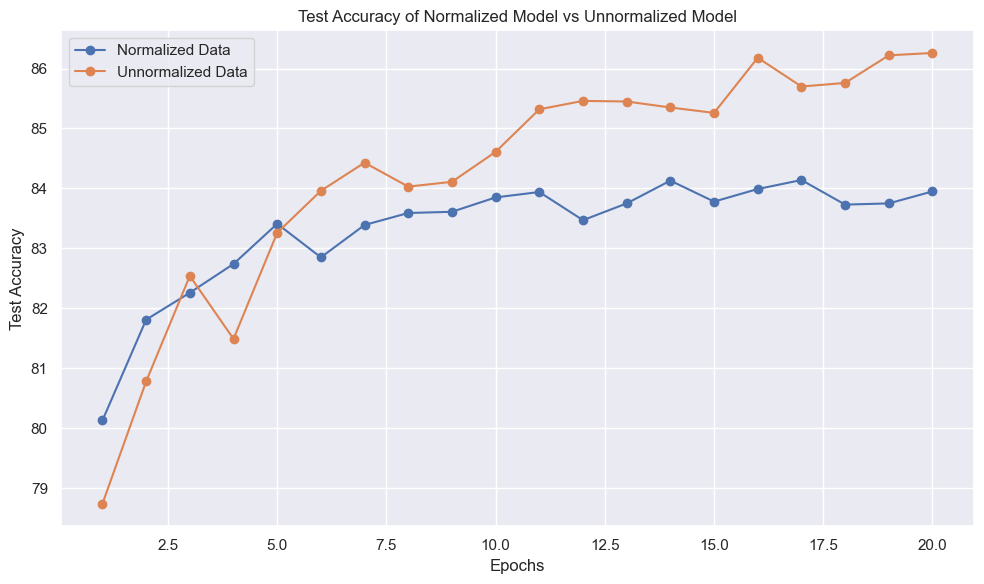

In [91]:
# Model with unnormalized images
mlp_transform_unnormalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x:x.view(-1))
])
full_train_dataset_unnormalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform_unnormalized)
test_dataset_unnormalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform_unnormalized)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_unnormalized))
val_size = len(full_train_dataset_unnormalized) - train_size

# add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_unnormalized, val_dataset_unnormalized = random_split(full_train_dataset_unnormalized, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader_unnormalized = DataLoader(train_dataset_unnormalized, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader_unnormalized = DataLoader(val_dataset_unnormalized, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_unnormalized = DataLoader(test_dataset_unnormalized, batch_size=batch_size, shuffle=False, generator=generator)

# comparison of unnormalized model vs normalized model
model_unnormalized = load_model('model3.4_unnormalized')
model_normalized = load_model('model1.3')
plt.figure(figsize=(10, 6))
if model_unnormalized is None: 
    model_unnormalized = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model_unnormalized.fit(train_loader_unnormalized, test_loader_unnormalized, 0.01, 20)
    save_model(model_unnormalized, 'model3.4_unnormalized')

if model_normalized is not None:
    plt.plot(range(1, len(model_normalized.test_accuracy_history) + 1), [a*100 for a in model_normalized.test_accuracy_history], marker='o', label=f'Normalized Data')
plt.plot(range(1, len(model_unnormalized.test_accuracy_history) + 1), [a*100 for a in model_unnormalized.test_accuracy_history], marker='o', label=f'Unnormalized Data')
plt.title('Test Accuracy of Normalized Model vs Unnormalized Model')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.5 MLP with Data Augmentation

Model loaded from saved_models/model3.5_augmented.pkl
Model loaded from saved_models/model1.3.pkl


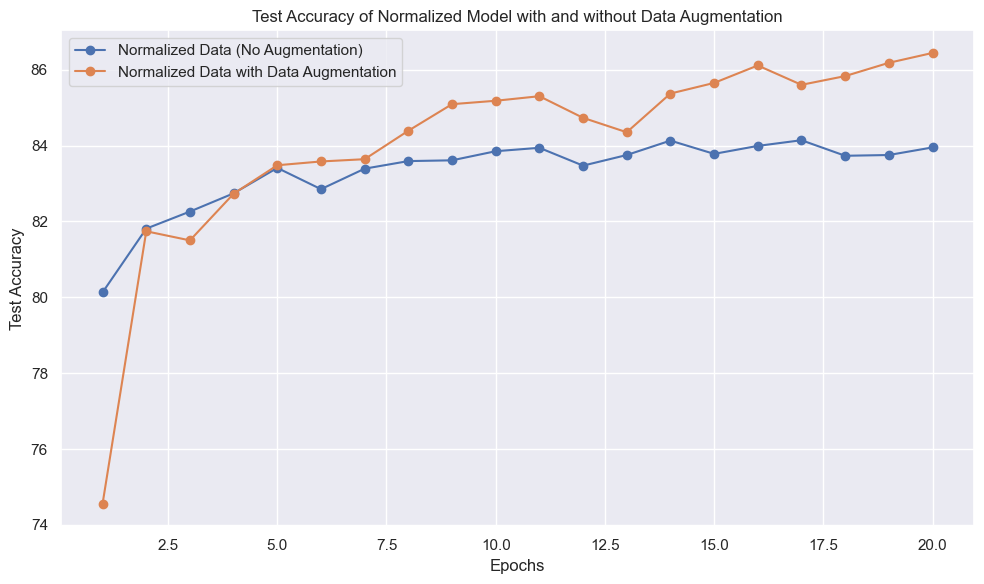

In [7]:
# Model with data augmentation (random horizontal flip and random rotation)
mlp_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
full_train_dataset_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_data_augmentation))
val_size = len(full_train_dataset_data_augmentation) - train_size

# add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_data_augmentation, val_dataset_data_augmentation = random_split(full_train_dataset_data_augmentation, [train_size, val_size], generator=generator)

# create dataloader -- note that we use the same test_loader as before (no augmentation on test set)
batch_size = 64
train_loader_data_augmentation = DataLoader(train_dataset_data_augmentation, batch_size=batch_size, shuffle=True, generator=generator)

# comparison of augmented model vs normalized model
model_augmented = load_model('model3.5_augmented')
model_normalized = load_model('model1.3')
plt.figure(figsize=(10, 6))
if model_augmented is None: 
    model_augmented = MLP(input_size, output_size, activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model_augmented.fit(train_loader_unnormalized, test_loader_unnormalized, 0.01, 20)
    save_model(model_augmented, 'model3.5_augmented')

if model_normalized is not None:
    plt.plot(range(1, len(model_normalized.test_accuracy_history) + 1), [a*100 for a in model_normalized.test_accuracy_history], marker='o', label=f'Normalized Data (No Augmentation)')
plt.plot(range(1, len(model_augmented.test_accuracy_history) + 1), [a*100 for a in model_augmented.test_accuracy_history], marker='o', label=f'Normalized Data with Data Augmentation')
plt.title('Test Accuracy of Normalized Model with and without Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.6: CNN Using Pytorch

In [24]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: mps


### CNN-specific Data Transformation

In [16]:
# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size])

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))


### CCN Class

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # 28x28 -> conv -> pool -> 14x14
        # 14x14 -> conv -> pool -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # -> 32x14x14
        x = self.pool(self.relu(self.conv2(x)))   # -> 64x7x7

        x = x.view(-1, 64 * 7 * 7)             # flatten

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### CNN Initialization

In [12]:
# Initialize CNN model
learning_rate = 0.001
cnn = CNN().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

### CCN Training

In [18]:
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    cnn.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients from previous batch
        
        outputs = cnn(images)
        preds = torch.argmax(outputs, dim=1)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += len(preds)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_cnn:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn(images)
            preds = torch.argmax(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_correct += (preds == labels).sum().item()
            val_total += len(preds)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # Test accuracy (on the full test set)
    cnn.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader_cnn:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn(images)
            preds = torch.argmax(outputs, dim=1)

            test_correct += (preds == labels).sum().item()
            test_total += len(preds)
    test_acc = test_correct / test_total
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train loss={epoch_loss:.4f}, Train acc={epoch_acc*100:.2f}%, Val loss={val_epoch_loss:.4f}, Val acc={val_epoch_acc*100:.2f}%, Test acc={test_acc*100:.2f}%')

end_time = time.time()

Epoch 1/10: Train loss=0.0008, Train acc=98.11%, Val loss=0.0054, Val acc=91.83%, Test acc=91.13%
Epoch 2/10: Train loss=0.0006, Train acc=98.56%, Val loss=0.0054, Val acc=91.88%, Test acc=91.73%
Epoch 3/10: Train loss=0.0006, Train acc=98.70%, Val loss=0.0062, Val acc=90.94%, Test acc=90.40%
Epoch 4/10: Train loss=0.0004, Train acc=99.03%, Val loss=0.0065, Val acc=91.92%, Test acc=91.66%
Epoch 5/10: Train loss=0.0004, Train acc=99.05%, Val loss=0.0067, Val acc=91.89%, Test acc=91.51%
Epoch 6/10: Train loss=0.0004, Train acc=99.13%, Val loss=0.0074, Val acc=91.62%, Test acc=91.06%
Epoch 7/10: Train loss=0.0004, Train acc=99.10%, Val loss=0.0075, Val acc=91.51%, Test acc=91.55%
Epoch 8/10: Train loss=0.0003, Train acc=99.26%, Val loss=0.0070, Val acc=92.19%, Test acc=92.05%
Epoch 9/10: Train loss=0.0003, Train acc=99.44%, Val loss=0.0074, Val acc=92.01%, Test acc=91.68%
Epoch 10/10: Train loss=0.0003, Train acc=99.36%, Val loss=0.0077, Val acc=92.01%, Test acc=91.60%


### Plot results

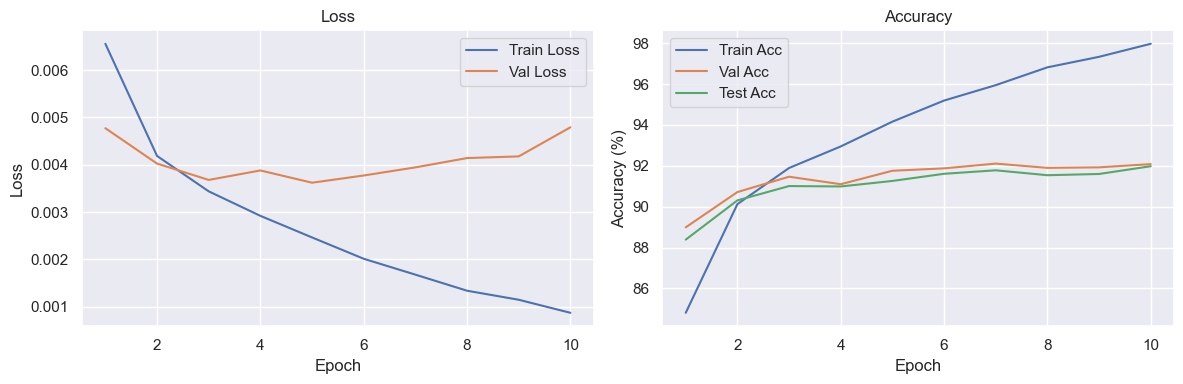

In [14]:
# Plot training/validation history
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), [a*100 for a in train_accuracies], label='Train Acc')
plt.plot(range(1, num_epochs+1), [a*100 for a in val_accuracies], label='Val Acc')
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies], label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Results Confusion Matrix

(10, 10)


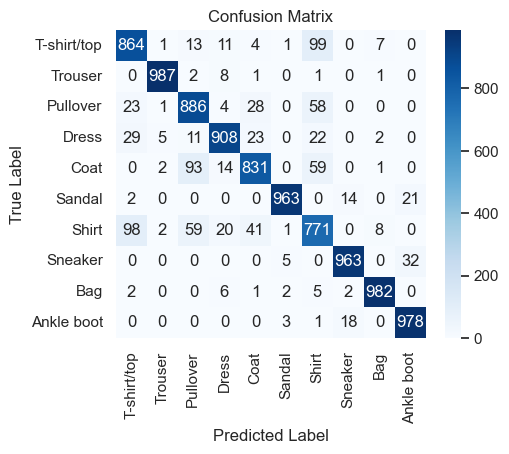

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = cnn(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3.7: CNN with Data Augmentation

In [17]:
cnn_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

full_train_cnn_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn_data_augmentation))
val_size = len(full_train_cnn_data_augmentation) - train_size
# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn_data_augmentation, val_dataset_cnn_data_augmentation = random_split(full_train_cnn_data_augmentation, [train_size, val_size], generator=generator)

batch_size = 64
train_loader_cnn_data_augmentation = DataLoader(train_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=True)
val_loader_cnn_data_augmentation = DataLoader(val_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=False)
test_loader_cnn_data_augmentation = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

In [ ]:
cnn_aug = CNN().to(device)
optimizer = optim.Adam(cnn_aug.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# train CNN 
num_epochs = 10
train_losses_aug = []
train_accuracies_aug = []
val_losses_aug = []
val_accuracies_aug = []
test_accuracies_aug = []
start_time_aug = time.time()

for epoch in range(num_epochs):
    cnn_aug.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_cnn_data_augmentation:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients from previous batch
        
        outputs = cnn_aug(images)
        preds = torch.argmax(outputs, dim=1)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += len(preds)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    train_losses_aug.append(epoch_loss)
    train_accuracies_aug.append(epoch_acc)

    # Validation
    cnn_aug.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_cnn_data_augmentation:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn_aug(images)
            preds = torch.argmax(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_correct += (preds == labels).sum().item()
            val_total += len(preds)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses_aug.append(val_epoch_loss)
    val_accuracies_aug.append(val_epoch_acc)

    # Test accuracy (on the full test set)
    cnn_aug.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader_cnn_data_augmentation:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn_aug(images)
            preds = torch.argmax(outputs, dim=1)

            test_correct += (preds == labels).sum().item()
            test_total += len(preds)
    test_acc = test_correct / test_total
    test_accuracies_aug.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train loss={epoch_loss:.4f}, Train acc={epoch_acc*100:.2f}%, Val loss={val_epoch_loss:.4f}, Val acc={val_epoch_acc*100:.2f}%, Test acc={test_acc*100:.2f}%')

end_time_aug = time.time()

Epoch 1/10: Train loss=0.0071, Train acc=83.35%, Val loss=0.0057, Val acc=86.62%, Test acc=86.03%
Epoch 2/10: Train loss=0.0047, Train acc=89.05%, Val loss=0.0043, Val acc=90.12%, Test acc=89.92%
Epoch 3/10: Train loss=0.0040, Train acc=90.57%, Val loss=0.0042, Val acc=90.20%, Test acc=90.20%
Epoch 4/10: Train loss=0.0036, Train acc=91.56%, Val loss=0.0041, Val acc=90.56%, Test acc=90.74%
Epoch 5/10: Train loss=0.0032, Train acc=92.39%, Val loss=0.0037, Val acc=91.27%, Test acc=91.06%
Epoch 6/10: Train loss=0.0029, Train acc=93.00%, Val loss=0.0035, Val acc=91.92%, Test acc=91.88%
Epoch 7/10: Train loss=0.0027, Train acc=93.57%, Val loss=0.0040, Val acc=90.94%, Test acc=91.23%
Epoch 8/10: Train loss=0.0025, Train acc=93.96%, Val loss=0.0036, Val acc=91.77%, Test acc=91.95%
Epoch 9/10: Train loss=0.0023, Train acc=94.47%, Val loss=0.0037, Val acc=91.78%, Test acc=91.92%
Epoch 10/10: Train loss=0.0021, Train acc=94.94%, Val loss=0.0036, Val acc=92.20%, Test acc=91.54%


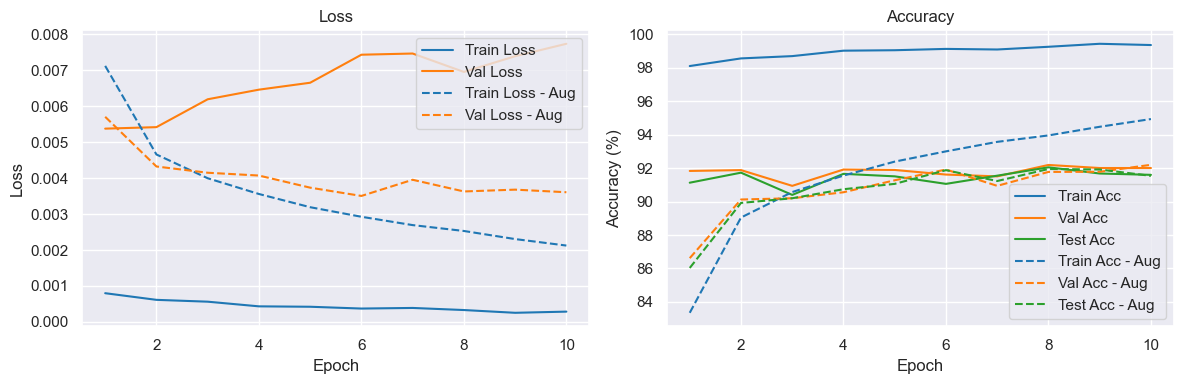

Training time without augmentation: 340.63 seconds
Training time with augmentation: 392.03 seconds


In [22]:
# Plot training/validation history of augmented CNN on top of original CNN
plt.figure(figsize=(12,4))
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color=colors[0])
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss', color=colors[1])
plt.plot(range(1, num_epochs+1), train_losses_aug, label='Train Loss - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, num_epochs+1), val_losses_aug, label='Val Loss - Aug', linestyle='--', color=colors[1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), [a*100 for a in train_accuracies], label='Train Acc', color=colors[0])
plt.plot(range(1, num_epochs+1), [a*100 for a in val_accuracies], label='Val Acc', color=colors[1])
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies], label='Test Acc', color=colors[2])
plt.plot(range(1, num_epochs+1), [a*100 for a in train_accuracies_aug], label='Train Acc - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, num_epochs+1), [a*100 for a in val_accuracies_aug], label='Val Acc - Aug', linestyle='--', color=colors[1])
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies_aug], label='Test Acc - Aug', linestyle ='--', color=colors[2])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare training times
print(f"Training time without augmentation: {end_time - start_time:.2f} seconds")
print(f"Training time with augmentation: {end_time_aug - start_time_aug:.2f} seconds")

## 3.8: Pretrained ResNet 

### Load ResNet18

In [19]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchinfo import summary
# Load a pre-trained ResNet-18 model
ResNet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
summary(ResNet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

### Prepare ResNet18 for Modification

In [20]:
# Freeze all convolutional layers
for param in ResNet18.parameters():
    param.requires_grad = False

# Modify First Layer for Grayscale Input
ResNet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Remove the fully connected layers (fc layer)
ResNet18.fc = nn.Identity() # Replace fc with identity # type: ignore
summary(ResNet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11     

### Custom ResNet18 Class

In [27]:
class CustomResNet18(nn.Module):
    def __init__(self, resnet, num_classes=10):
        super(CustomResNet18, self).__init__()
        # Load the pre-trained ResNet18
        self.resnet = resnet

        # Add custom layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc_layers(x)
        return x

### Custom ResNet18 Initialization

In [28]:
# Initialize Custom Resnet model
learning_rate = 0.001
custom_resnet18 = CustomResNet18(ResNet18, num_classes=10).to(device)
optimizer = optim.Adam(custom_resnet18.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [22]:
summary(custom_resnet18)

Layer (type:depth-idx)                        Param #
CustomResNet18                                --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,640

### Custom ResNet18 Training

In [29]:
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    custom_resnet18.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_cnn_data_augmentation:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients from previous batch
        
        outputs = custom_resnet18(images)
        preds = torch.argmax(outputs, dim=1)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += len(preds)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    custom_resnet18.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_cnn_data_augmentation:
            images, labels = images.to(device), labels.to(device)
            
            outputs = custom_resnet18(images)
            preds = torch.argmax(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_correct += (preds == labels).sum().item()
            val_total += len(preds)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # Test accuracy (on the full test set)
    custom_resnet18.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader_cnn_data_augmentation:
            images, labels = images.to(device), labels.to(device)
            
            outputs = custom_resnet18(images)
            preds = torch.argmax(outputs, dim=1)

            test_correct += (preds == labels).sum().item()
            test_total += len(preds)
    test_acc = test_correct / test_total
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train loss={epoch_loss:.4f}, Train acc={epoch_acc*100:.2f}%, Val loss={val_epoch_loss:.4f}, Val acc={val_epoch_acc*100:.2f}%, Test acc={test_acc*100:.2f}%')

Epoch 1/10: Train loss=0.0151, Train acc=64.70%, Val loss=0.0123, Val acc=71.88%, Test acc=72.64%
Epoch 2/10: Train loss=0.0118, Train acc=72.28%, Val loss=0.0110, Val acc=74.74%, Test acc=73.80%
Epoch 3/10: Train loss=0.0108, Train acc=74.68%, Val loss=0.0096, Val acc=77.49%, Test acc=78.10%
Epoch 4/10: Train loss=0.0102, Train acc=76.17%, Val loss=0.0096, Val acc=77.66%, Test acc=77.64%
Epoch 5/10: Train loss=0.0098, Train acc=76.77%, Val loss=0.0092, Val acc=78.42%, Test acc=78.97%
Epoch 6/10: Train loss=0.0096, Train acc=77.52%, Val loss=0.0095, Val acc=77.76%, Test acc=78.68%
Epoch 7/10: Train loss=0.0093, Train acc=78.15%, Val loss=0.0091, Val acc=79.30%, Test acc=79.72%
Epoch 8/10: Train loss=0.0090, Train acc=78.75%, Val loss=0.0086, Val acc=79.98%, Test acc=80.83%
Epoch 9/10: Train loss=0.0088, Train acc=79.19%, Val loss=0.0086, Val acc=80.47%, Test acc=80.23%
Epoch 10/10: Train loss=0.0088, Train acc=79.49%, Val loss=0.0084, Val acc=80.58%, Test acc=80.10%


### Plot Results

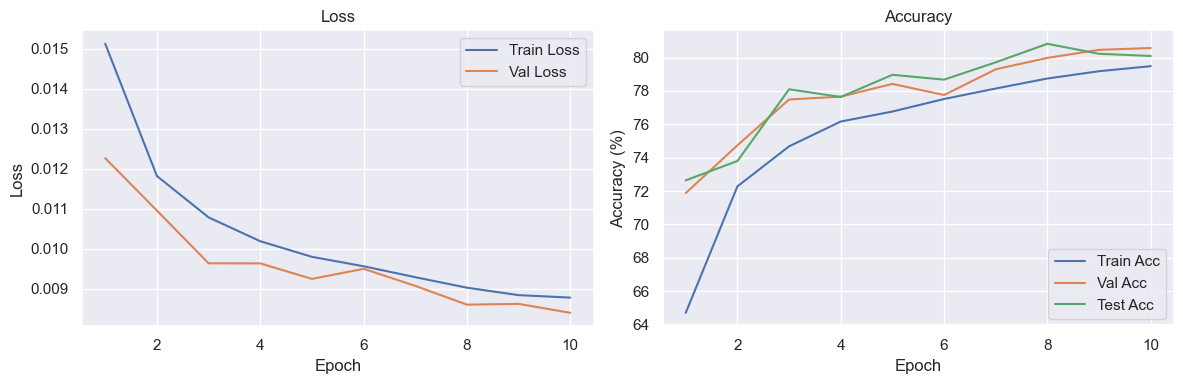

In [34]:
# Plot training/validation history
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), [a*100 for a in train_accuracies], label='Train Acc')
plt.plot(range(1, num_epochs+1), [a*100 for a in val_accuracies], label='Val Acc')
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies], label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Results Confusion Matrix

(10, 10)


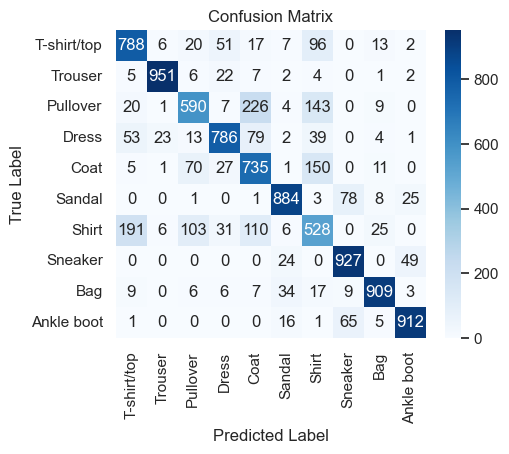

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

custom_resnet18.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn_data_augmentation:
        images = images.to(device)
        outputs = custom_resnet18(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()